In [0]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

In [0]:
import os
import numpy as np
import cv2 as cv
from PIL import Image
from pprint import pprint
import glob
from google.colab.patches import cv2_imshow
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier, RandomTreesEmbedding
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import AdditiveChi2Sampler
from sklearn.svm import SVC

In [0]:
from google.colab import drive
drive.mount('/content/drive/')
os.chdir("/content/drive/My Drive/Caltech_101/101_ObjectCategories/")

# Data ingestion

In [0]:
# get the image data from the google drive 
# the 10 labels are predifined

labels = ["tick", "trilobite", "umbrella", "watch", "water_lilly", "wheelchair", "wild_cat", "windsor_chair", "wrench", "yin_yang"]
images = []
for label in labels:
  image_list = list(map(Image.open, glob.glob('{l}/*.jpg'.format(l=label))))
  images.append(image_list)
images = np.array(images)

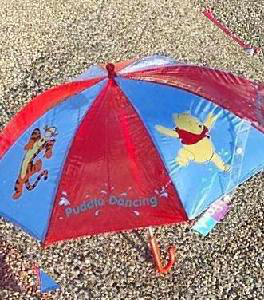

In [0]:
images[2][0]

In [0]:
# split the dat ain training and test with 10 classes in total of 15 images each
x_train, x_test = [], []
n_train, n_test = 15, 15
for l in images:
  x_train.append((l[:n_train]))
  x_test.append((l[-n_test:]))

# SIFT

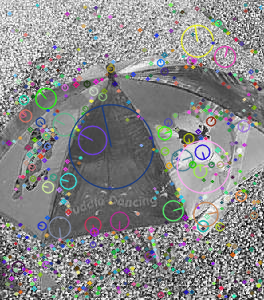

In [0]:
# img = cv.imread(x_train[2][0], 0)
img = cv.cvtColor(np.array(x_train[2][0]), cv.COLOR_RGB2GRAY)

sift = cv.xfeatures2d.SIFT_create()
kp, des = sift.detectAndCompute(img, None)

kp_img = cv.drawKeypoints(img, kp, img, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

cv2_imshow(kp_img)

In [0]:
# create ndarray of the sifts of each image. 
# have one array where is distributed per image - single
# have another array where all the sifts are in, independendt of their class - joint

def sift_data(x):
  kp_train_single = []
  sift = cv.xfeatures2d.SIFT_create()
  for label_img in x:
    kp_img_category = []
    for l in label_img:
      img = cv.cvtColor(np.array(l), cv.COLOR_RGB2GRAY) if l.mode == 'RGB' else np.array(l)
      kp, des = sift.detectAndCompute(img, None)
      kp_img_category.append(des)
    kp_train_single.append(kp_img_category)
  kp_train_single = np.array(kp_train_single)
  return np.vstack(np.ndarray.flatten(kp_train_single))

In [0]:
kp_train_joint = sift_data(x_train)
kp_train_joint.shape

(65196, 128)

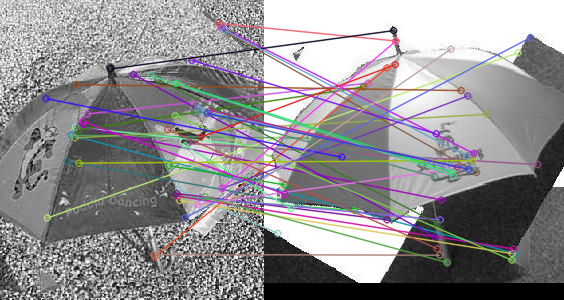

In [0]:
# matching representation

umb1 = x_train[2][0]
umb2 = x_train[2][1]

umb1 = cv.cvtColor(np.array(umb1), cv.COLOR_RGB2GRAY) if umb1.mode == 'RGB' else np.array(umb1)
umb2 = cv.cvtColor(np.array(umb2), cv.COLOR_RGB2GRAY) if umb2.mode == 'RGB' else np.array(umb2)

sift = cv.xfeatures2d.SIFT_create()

kp1, des1 = sift.detectAndCompute(umb1, None)
kp2, des2 = sift.detectAndCompute(umb2, None)

# feature matching
bf = cv.BFMatcher(cv.NORM_L1, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x:x.distance)

match_img = cv.drawMatches(umb1, kp1, umb2, kp2, matches[:50], umb2, flags=2)
cv2_imshow(match_img)

# Visual vocabulary construction (Codewords)

In [0]:
# standarise data 
data = scale(kp_train_joint, axis=1)  # standarise each of the 65k samples
data.shape

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(65196, 128)

In [0]:
# pca
# pca = PCA(0.99, whiten=True)    # preserve 99% of the variance in the data
# data_pca = pca.fit_transform(data)
# data_pca.shape

(65196, 109)

## Finding optimum cluster number K with AIC & BIC


In [0]:
# test different cluster numbers k
k_models = dict()
for k in range(100, 1000, 50):
  kmeans = MiniBatchKMeans(init ='k-means++', n_clusters = k, 
                           batch_size = 1000, n_init = 10, 
                           random_state=1, verbose = 0).fit(data) 
  k_models[k] = (kmeans.inertia_, kmeans)                     

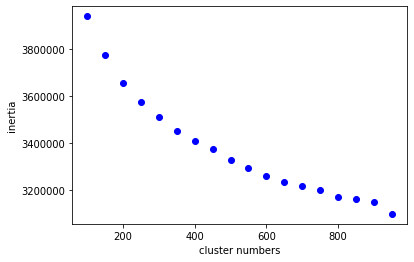

In [0]:
# draw cluster vs. inertia to observe elbow method
inertias = [inertia for inertia,model in k_models.values()]
k_clusters = [k for k in k_models.keys()]

plt.plot(k_clusters, inertias, 'bo')
plt.ylabel('inertia')
plt.xlabel('cluster numbers')
plt.show()

In [0]:
# gaussian model to obtain the aic
n_components = np.arange(50, 500, 50)
gmm = {k:GaussianMixture(k, covariance_type='diag', random_state=0, verbose=2).fit(data) for k in n_components}

Initialization 0
  Iteration 10	 time lapse 23.65654s	 ll change 0.23476
  Iteration 20	 time lapse 9.00592s	 ll change 0.05816
  Iteration 30	 time lapse 9.04456s	 ll change 0.03086
  Iteration 40	 time lapse 9.08274s	 ll change 0.01315
  Iteration 50	 time lapse 9.16140s	 ll change 0.00882
  Iteration 60	 time lapse 9.15987s	 ll change 0.00384
  Iteration 70	 time lapse 9.02587s	 ll change 0.00367
  Iteration 80	 time lapse 8.96398s	 ll change 0.00116
  Iteration 90	 time lapse 9.08113s	 ll change 0.00105
Initialization converged: True	 time lapse 97.08697s	 ll -103.26798
Initialization 0
  Iteration 10	 time lapse 36.65073s	 ll change 0.26807
  Iteration 20	 time lapse 18.05785s	 ll change 0.06460
  Iteration 30	 time lapse 18.04112s	 ll change 0.02960
  Iteration 40	 time lapse 18.16603s	 ll change 0.01798
  Iteration 50	 time lapse 17.97979s	 ll change 0.01005
  Iteration 60	 time lapse 18.01732s	 ll change 0.00696
  Iteration 70	 time lapse 18.06339s	 ll change 0.00639
  Iteratio

/usr/local/lib/python3.6/dist-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Initialization 0
  Iteration 10	 time lapse 50.96216s	 ll change 0.28633
  Iteration 20	 time lapse 26.76909s	 ll change 0.07569
  Iteration 30	 time lapse 26.68289s	 ll change 0.02981
  Iteration 40	 time lapse 26.66652s	 ll change 0.02266
  Iteration 50	 time lapse 26.34923s	 ll change 0.01479
  Iteration 60	 time lapse 26.54042s	 ll change 0.01016
  Iteration 70	 time lapse 26.47072s	 ll change 0.00771
  Iteration 80	 time lapse 26.56844s	 ll change 0.00619
  Iteration 90	 time lapse 26.51294s	 ll change 0.00526
  Iteration 100	 time lapse 26.43393s	 ll change 0.00514
Initialization converged: False	 time lapse 289.95687s	 ll -89.04303


/usr/local/lib/python3.6/dist-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Initialization 0
  Iteration 10	 time lapse 65.59768s	 ll change 0.27121
  Iteration 20	 time lapse 36.55697s	 ll change 0.07890
  Iteration 30	 time lapse 36.55591s	 ll change 0.02585
  Iteration 40	 time lapse 36.34193s	 ll change 0.01387
  Iteration 50	 time lapse 36.29229s	 ll change 0.01015
  Iteration 60	 time lapse 36.34719s	 ll change 0.00822
  Iteration 70	 time lapse 36.28388s	 ll change 0.00597
  Iteration 80	 time lapse 36.27261s	 ll change 0.00591
  Iteration 90	 time lapse 36.07354s	 ll change 0.00604
  Iteration 100	 time lapse 36.45032s	 ll change 0.00582
Initialization converged: False	 time lapse 392.77295s	 ll -85.66580


/usr/local/lib/python3.6/dist-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Initialization 0
  Iteration 10	 time lapse 78.51576s	 ll change 0.25198
  Iteration 20	 time lapse 46.01660s	 ll change 0.06635
  Iteration 30	 time lapse 46.12014s	 ll change 0.03038
  Iteration 40	 time lapse 45.71571s	 ll change 0.02063
  Iteration 50	 time lapse 45.38338s	 ll change 0.01372
  Iteration 60	 time lapse 45.34535s	 ll change 0.01110
  Iteration 70	 time lapse 45.43344s	 ll change 0.00906
  Iteration 80	 time lapse 45.23188s	 ll change 0.00940
  Iteration 90	 time lapse 45.10908s	 ll change 0.00888
  Iteration 100	 time lapse 45.18391s	 ll change 0.00723
Initialization converged: False	 time lapse 488.05575s	 ll -82.70210


/usr/local/lib/python3.6/dist-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Initialization 0
  Iteration 10	 time lapse 96.10270s	 ll change 0.29674
  Iteration 20	 time lapse 55.68873s	 ll change 0.06374
  Iteration 30	 time lapse 54.97110s	 ll change 0.02968
  Iteration 40	 time lapse 54.90593s	 ll change 0.01756
  Iteration 50	 time lapse 54.94186s	 ll change 0.01241
  Iteration 60	 time lapse 54.92476s	 ll change 0.01227
  Iteration 70	 time lapse 55.03932s	 ll change 0.00730
  Iteration 80	 time lapse 54.88138s	 ll change 0.00682
  Iteration 90	 time lapse 54.81465s	 ll change 0.00472
  Iteration 100	 time lapse 55.10002s	 ll change 0.00304
Initialization converged: False	 time lapse 591.37098s	 ll -80.58256


/usr/local/lib/python3.6/dist-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Initialization 0
  Iteration 10	 time lapse 112.15552s	 ll change 0.28144
  Iteration 20	 time lapse 67.52401s	 ll change 0.07199
  Iteration 30	 time lapse 66.73724s	 ll change 0.04436
  Iteration 40	 time lapse 66.73626s	 ll change 0.02302
  Iteration 50	 time lapse 66.39955s	 ll change 0.01689
  Iteration 60	 time lapse 66.32036s	 ll change 0.01205
  Iteration 70	 time lapse 66.63514s	 ll change 0.00964
  Iteration 80	 time lapse 66.27898s	 ll change 0.00630
  Iteration 90	 time lapse 66.41835s	 ll change 0.00530
  Iteration 100	 time lapse 66.09748s	 ll change 0.00318
Initialization converged: False	 time lapse 711.30338s	 ll -78.51867


/usr/local/lib/python3.6/dist-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Initialization 0
  Iteration 10	 time lapse 127.87413s	 ll change 0.31040
  Iteration 20	 time lapse 77.34349s	 ll change 0.07614
  Iteration 30	 time lapse 77.07458s	 ll change 0.03445
  Iteration 40	 time lapse 76.82814s	 ll change 0.01889
  Iteration 50	 time lapse 76.83408s	 ll change 0.01171
  Iteration 60	 time lapse 76.80213s	 ll change 0.01028
  Iteration 70	 time lapse 76.76056s	 ll change 0.00722
  Iteration 80	 time lapse 76.55845s	 ll change 0.00519
  Iteration 90	 time lapse 76.53356s	 ll change 0.00356
  Iteration 100	 time lapse 76.54340s	 ll change 0.00289
Initialization converged: False	 time lapse 819.15472s	 ll -77.03176


/usr/local/lib/python3.6/dist-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Initialization 0
  Iteration 10	 time lapse 137.96485s	 ll change 0.27018
  Iteration 20	 time lapse 87.56182s	 ll change 0.08074
  Iteration 30	 time lapse 87.58564s	 ll change 0.03732
  Iteration 40	 time lapse 87.34162s	 ll change 0.02459
  Iteration 50	 time lapse 87.60898s	 ll change 0.01580
  Iteration 60	 time lapse 86.99739s	 ll change 0.01182
  Iteration 70	 time lapse 87.01020s	 ll change 0.00866
  Iteration 80	 time lapse 86.57770s	 ll change 0.00507
  Iteration 90	 time lapse 86.73572s	 ll change 0.00413
  Iteration 100	 time lapse 86.75795s	 ll change 0.00361
Initialization converged: False	 time lapse 922.14239s	 ll -75.41795


/usr/local/lib/python3.6/dist-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


In [0]:
for k in range(600, 700, 50):
  gmm[k] = GaussianMixture(k, covariance_type='diag', random_state=0, verbose=2).fit(data)

Initialization 0
  Iteration 10	 time lapse 191.26290s	 ll change 0.29387
  Iteration 20	 time lapse 122.63887s	 ll change 0.08442
  Iteration 30	 time lapse 121.86783s	 ll change 0.03505
  Iteration 40	 time lapse 121.30032s	 ll change 0.02070
  Iteration 50	 time lapse 120.37697s	 ll change 0.01190
  Iteration 60	 time lapse 120.57169s	 ll change 0.00696
  Iteration 70	 time lapse 120.86796s	 ll change 0.00632
  Iteration 80	 time lapse 120.97301s	 ll change 0.00415
  Iteration 90	 time lapse 120.70926s	 ll change 0.00366
  Iteration 100	 time lapse 120.12741s	 ll change 0.00684
Initialization converged: False	 time lapse 1280.69674s	 ll -71.92550


/usr/local/lib/python3.6/dist-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Initialization 0
  Iteration 10	 time lapse 207.12668s	 ll change 0.27790
  Iteration 20	 time lapse 132.78018s	 ll change 0.06499
  Iteration 30	 time lapse 132.19019s	 ll change 0.02743
  Iteration 40	 time lapse 131.38493s	 ll change 0.01655
  Iteration 50	 time lapse 131.28849s	 ll change 0.01133
  Iteration 60	 time lapse 131.13734s	 ll change 0.01174
  Iteration 70	 time lapse 130.75005s	 ll change 0.00733
  Iteration 80	 time lapse 131.03591s	 ll change 0.01007
  Iteration 90	 time lapse 130.17248s	 ll change 0.00724
  Iteration 100	 time lapse 130.46359s	 ll change 0.00492
Initialization converged: False	 time lapse 1388.33052s	 ll -71.11791


/usr/local/lib/python3.6/dist-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


In [0]:
aics = [model.aic(data) for model in gmm.values()]
bics = [model.bic(data) for model in gmm.values()]

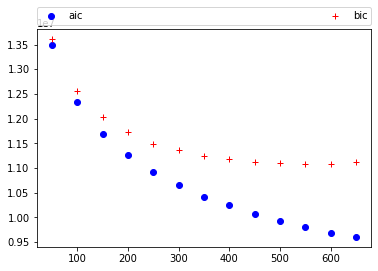

In [0]:
plt.plot(list(gmm.keys()), aics, 'bo', label="aic")
plt.plot(list(gmm.keys()), bics, 'r+', label="bic")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

## K-Means

In [0]:
# perform kmeans with k clusters and pca data
k = 250

kmeans = KMeans(init ='k-means++', n_clusters = k, n_init = 10, 
                random_state=0, verbose = 0).fit(data) 

In [0]:
codewords = kmeans.cluster_centers_
codewords.shape

(250, 128)

## Random Trees Embedding

In [0]:
rtree = RandomTreesEmbedding(n_estimators=1000, max_depth=70, 
                             min_samples_leaf=1, min_samples_split=2,
                             verbose=1, random_state=0)

In [0]:
rtree.fit(data)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   32.9s finished


RandomTreesEmbedding(max_depth=70, max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=1000,
                     n_jobs=None, random_state=0, sparse_output=True, verbose=1,
                     warm_start=False)

In [0]:
# For each datapoint x in X and for each tree in the forest, 
# return the index of the leaf x ends up in.
leafs = rtree.apply(data)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   34.6s finished


In [0]:
leafs.shape

(65196, 1000)

# Histogram of visual words

In [0]:
# note how many SIFTs are per image knowing there are 150 images

def count_sifts_per_image(x):
  sift = cv.xfeatures2d.SIFT_create()
  n_sift = []
  for label_img in x:
    for l in label_img:
      img = cv.cvtColor(np.array(l), cv.COLOR_RGB2GRAY) if l.mode == 'RGB' else np.array(l)
      kp, des = sift.detectAndCompute(img, None)
      n_sift.append(des.shape[0])
  return n_sift

In [0]:
train_n_sift = count_sifts_per_image(x_train)
len(train_n_sift)

150

In [0]:
# vw = visual words
def visualWords(data):
  vw = []
  p1, p2 = 0, 0
  for n in train_n_sift:
    p2 += n 
    vw.append(data[p1:p2])
    p1 = p2
  return np.array(vw)

In [0]:
# KMeans codebook
vw = visualWords(data)

In [0]:
# Nearest Neighbour

# tree data
nn = NearestNeighbors(n_neighbors=1, algorithm='brute').fit(trees_data)

# balltree
# nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(trees_data)

# kd_tree
# nn = NearestNeighbors(n_neighbors=1, algorithm='kd_tree').fit(codewords)

# brute
# nn = NearestNeighbors(n_neighbors=1, algorithm='kd_tree').fit(codewords)

In [0]:
# build histogram of images
# the dictionary key corresponds to the index of the codeword
# the dictionary value corresponds to the frequency of that codeword 

train_hist = []
for img in vw:
  histogram = defaultdict(int)
  for visual_word in img:
    dist, index = nn.kneighbors([visual_word])
    histogram[index[0][0]] += 1
  train_hist.append(histogram)

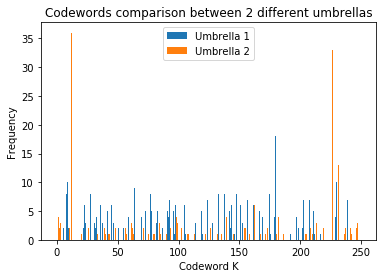

In [0]:
 # draw the image with its codeword representation
class_number = 2  # umbrella
img_number = class_number*15 + 0

labels = np.arange(codewords.shape[0])
umb1 = [0 for _ in range(codewords.shape[0])]
umb2 = [0 for _ in range(codewords.shape[0])]
for u1,u2 in zip(train_hist[img_number].items(), train_hist[img_number+1].items()):
  k1, f1 = u1
  k2, f2 = u2
  umb1[k1], umb2[k2] = f1, f2  

width = 0.5
fig, ax = plt.subplots()
rects1 = ax.bar(labels-width/2, umb1, width, label='Umbrella 1')
rects2 = ax.bar(labels+width/2, umb2, width, label='Umbrella 2')

ax.set_ylabel('Frequency')
ax.set_title('Codewords comparison between 2 different umbrellas')
ax.set_xlabel('Codeword K')
ax.legend()

# fig.tight_layout()
plt.show()


# Random Forest (RF)

In [0]:
# RF codebook
rf_train_features = visualWords(leafs)
rf_train_features.shape

(150,)

In [0]:
labels = ["tick", "trilobite", "umbrella", "watch", "water_lilly", "wheelchair", "wild_cat", "windsor_chair", "wrench", "yin_yang"]
y_train = []
for label in labels:
  y_train.append([label]*n_train)
y = np.array(y_train).flatten()
y.shape

(150,)

In [0]:
# create data array for training RF

def data_for_RF(histogram):
  data = np.zeros((150,k), dtype=int)
  for idx,img in enumerate(histogram):
    for key,val in img.items():
      data[idx][key] = val
  return data 

In [0]:
train_features = data_for_RF(train_hist)
train_features.shape

(150, 250)

### Cross Validation (CV)

In [0]:
"""
n_estimators: number of trees to be used in the forest
max_features: max number of features to consider for splitting a node
max_depth: max number of levels in each decision tree
min_samples_split: min number of data points placed in a node before the node is split
min_samples_leaf: min number of data points allowed in a leaf node
bootstrap: method for sampling data points (with or without replacement)
"""

{'bootstrap': True,
 'max_depth': 70,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000}

rf = RandomForestClassifier(n_estimators=1000, criterion='gini', 
                            max_depth=70, min_samples_split=2, 
                            min_samples_leaf=1, max_features='auto',  
                            bootstrap=True, random_state=0, verbose=1)

In [0]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['sqrt', 'log2', 'auto']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['sqrt', 'log2', 'auto'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [0]:
# Use the random grid to search for best hyperparameters

# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
"""
n_iter: controls of different combinations to try
cv: number of folds to use for cross validation 
More iterations will cover a wider search space and 
more cv folds reduces the chances of overfitting, 
but raising each will increase the run time. 
Machine learning is a field of trade-offs, and performance 
vs time is one of the most fundamental.
"""

rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, 
                               random_state=0, n_jobs = -1)
# Fit the random search model
rf_random.fit(train_features, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.0min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [0]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 70,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000}

### Grid Search with CV

In [0]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [1, 2, 3],
    'n_estimators': [600, 800, 1200, 1400]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                           cv = 3, n_jobs = -1, verbose = 2)

In [0]:
# Fit the grid search to the data
grid_search.fit(train_features, y)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 12.3min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [0]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 1200}

### Create test features

In [0]:
# create test_features
test_features = sift_data(x_test)
test_features = scale(test_features, axis=1)  # standarise each of the 65k samples
pca = PCA(0.99, whiten=True)    # pca: preserve 99% of the variance in the data
# test_features = pca.fit_transform(test_features)
test_features.shape

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(66893, 128)

In [0]:
# count test sifts
test_n_sift = count_sifts_per_image(x_test)
# vw = visual words
vw_test = []
p1, p2 = 0, 0
for n in test_n_sift:
  p2 += n 
  vw_test.append(test_features[p1:p2])
  p1 = p2
vw_test = np.array(vw_test)
vw_test.shape

(150,)

In [0]:
# visual words to histogram representation using training codebook
test_hist = []
for img in vw_test:
  histogram = defaultdict(int)
  for visual_word in img:
    dist, index = nn.kneighbors([visual_word])
    histogram[index[0][0]] += 1
  test_hist.append(histogram)

In [0]:
test_features = data_for_RF(test_hist)
test_features.shape

(150, 250)

### Evaluate Random Search

In [0]:
model = rf.fit(rf_train_features, y)

In [0]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    correct = np.sum(predictions == test_labels)
    accuracy = correct/len(test_labels)*100
    print('Model Performance')
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

## Results

In [0]:
# sgd of chi squared kernel, 250 codewords
evaluate(model, test_features_transformed, y)

Model Performance
Accuracy = 46.67%.


46.666666666666664

In [0]:
# cross validation model without pca and 250 codewords and nn=brute-force
evaluate(rf_random.best_estimator_, test_features, y)

Model Performance
Accuracy = 72.67%.


72.66666666666667

In [0]:
# cross validation model without pca and 250 codewords and nn=kd_trees
evaluate(rf_random.best_estimator_, test_features, y)

Model Performance
Accuracy = 72.67%.


72.66666666666667

In [0]:
# grid search cross validation without pca and 250 codewords
evaluate(grid_search.best_estimator_, test_features, y)

Model Performance
Accuracy = 71.33%.


71.33333333333334

In [0]:
# cross validation model without pca and 250 codewords
evaluate(rf_random.best_estimator_, test_features, y)

Model Performance
Accuracy = 72.67%.


72.66666666666667

In [0]:
# default model without pca and 400 codewords 
# evaluate(model, test_features, y)

Model Performance
Accuracy = 66.00%.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


66.0

In [0]:
# default model without pca and 100 codewords 
# evaluate(model, test_features, y)

Model Performance
Accuracy = 65.33%.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


65.33333333333333

In [0]:
# default model without pca and 600 codewords 
# evaluate(model, test_features, y)

Model Performance
Accuracy = 60.67%.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


60.66666666666667

In [0]:
# default model without pca and 250 codewords
# evaluate(model, test_features, y)

Model Performance
Accuracy = 66.67%.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


66.66666666666666

In [0]:
# default model with pca and 250 codewords 
# evaluate(model, test_features, y)

Model Performance
Accuracy = 27.33%.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


27.333333333333332

In [0]:
# cross validation model with pca and 250 codewords
# evaluate(model, test_features, y)

Model Performance
Accuracy = 25.33%.


25.333333333333336

## Confussion Matrix

In [0]:
y_est = rf_random.best_estimator_.predict(test_features)
y_est

array(['tick', 'tick', 'wrench', 'wheelchair', 'tick', 'tick', 'tick',
       'tick', 'trilobite', 'watch', 'wheelchair', 'windsor_chair',
       'trilobite', 'wild_cat', 'tick', 'trilobite', 'trilobite',
       'trilobite', 'tick', 'trilobite', 'trilobite', 'trilobite',
       'yin_yang', 'trilobite', 'trilobite', 'wild_cat', 'trilobite',
       'yin_yang', 'trilobite', 'trilobite', 'yin_yang', 'wrench',
       'yin_yang', 'watch', 'umbrella', 'wrench', 'umbrella', 'umbrella',
       'wrench', 'umbrella', 'umbrella', 'water_lilly', 'yin_yang',
       'water_lilly', 'wrench', 'wheelchair', 'watch', 'watch',
       'wheelchair', 'watch', 'watch', 'watch', 'watch', 'watch',
       'wild_cat', 'watch', 'wrench', 'watch', 'watch', 'watch',
       'water_lilly', 'water_lilly', 'water_lilly', 'wild_cat',
       'water_lilly', 'water_lilly', 'umbrella', 'water_lilly',
       'umbrella', 'water_lilly', 'water_lilly', 'water_lilly',
       'water_lilly', 'water_lilly', 'water_lilly', 'wild_cat'

In [0]:
label = ["tick", "trilobite", "umbrella", "watch", "water_lilly", "wheelchair", "wild_cat", "windsor_chair", "wrench", "yin_yang"]
y = np.array([[l]*15 for l in label]).flatten()

In [0]:
np.sum(labels==y_est)/150*100

76.0

In [0]:
cf = confusion_matrix(y, y_est, label)

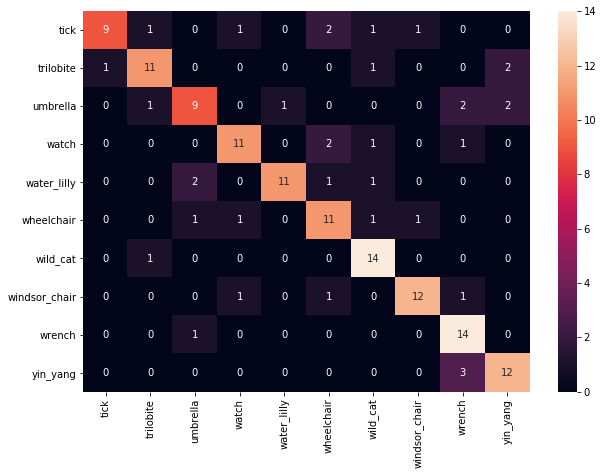

In [0]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(cf, index = [i for i in label],
                     columns = [i for i in label])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)